In [1]:
import os.path
import skimage.io as io
import sys
import math
import statistics as st
# import opencv
import numpy as np
from matplotlib import pyplot as plt

from skimage.transform import rotate


from skimage.feature import corner_harris, corner_subpix, \
    corner_peaks, corner_foerstner, corner_kitchen_rosenfeld, \
    corner_shi_tomasi

In [2]:
testImagesPath = os.path.join(os.getcwd(), 'test', 'set1')

In [3]:
def loadImages(path, n):
    images = []
    suffix = '.png'
    for i in range(n):
        filepath = os.path.join(path, str(i) + suffix)
        images.append(io.imread(filepath, as_gray=True))
    return images

In [4]:
img = loadImages(testImagesPath, 20)

In [5]:
def main():
    if len(sys.argv) != 3:
        print("Invalid number of args! Abort.")
        exit()
        
#     _, path, n = sys.argv
    path, n = testImagesPath, 6
    images = loadImages(path, int(n))

In [6]:
def entropy(_list):
    return -sum([p * math.log(p) if p > 0 else 0 for p in _list])

In [7]:
def distance(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return round(math.sqrt((x1-x2)**2 + (y1-y2)**2),3)

In [8]:
# usuwa niepotrzebne białe ramki; odpal przykład niżej
# 0 - top, 1 - bottom, 2 - left, 3 - right
def dropSideBorder(arr, side, n = 2): 
    if n <= 0:
        return arr
    
    _arr = arr
    while True:
        x, y = _arr.shape
        if side == 0:
            if n >= x: return _arr
            _to_sum = _arr[n]
            _next   = _arr[1:]
        elif side == 1:
            if n >= x: return _arr
            _to_sum = _arr[-n-1]
            _next   = _arr[:-1]
        elif side == 2:
            if n >= y: return _arr
            _to_sum = _arr[:,n]
            _next   = _arr[:,1:]
        elif side == 3:
            if n >= y: return _arr
            _to_sum = _arr[:,-n-1]
            _next   = _arr[:,:-1]
            
        if np.count_nonzero(_to_sum) == 0:
            _arr = _next
        else:
            return _arr
    
    return arr
    
def dropEmptyBorders(arr, n = 2):
    a = dropSideBorder(arr, 0, n)
    b = dropSideBorder(a, 1, n)
    c = dropSideBorder(b, 2, n)
    d = dropSideBorder(c, 3, n)
    return d

In [119]:
t = np.arange(225).reshape((15,15))
t[0:2] = 0
t[-5:] = 0
t[:,0:7] = 0
t[:,-3:] = 0

u = np.arange(9).reshape((3,3))
u *= 3

t[1:4, 1:4] = u

# print(u)
# print(t)
# print()
# print(dropEmptyBorders(t, 1))

In [120]:
def placeImageInNewAreaCenter(image):
    img_x = image.shape[0]    
    img_y = image.shape[1]
    result = np.zeros((img_x*3, img_y*3))
    _x = int(img_x)  
    _y = int(img_y)
    
    result[_x:_x+img_x, _y:_y+img_y] = image
    return result

In [121]:
t = np.arange(9).reshape((3,3)) + 1
print(t)
print(placeImageInNewAreaCenter(t))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 2. 3. 0. 0. 0.]
 [0. 0. 0. 4. 5. 6. 0. 0. 0.]
 [0. 0. 0. 7. 8. 9. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [106]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import regionprops, profile_line

In [11]:
# robi tak fajnie, że obraz ma szerokość X równą podanemu 'n'
def normalise_img_size(img, size = 1024):
    y_scale = size / img.shape[1]
    image_resized = resize(img, (round(y_scale * img.shape[0]), size), anti_aliasing=True)
    image_resized = np.where(image_resized > 0.5, 1.0, 0.0)
    return image_resized

In [12]:
# wyznacza punkt z listy, który jest najbliżej podanego
def nearestPointTo(point, points):
    distance_list = [(distance(point, p), p) for p in points]
    _points = [p for _, p in sorted(distance_list)]
    return _points[0]

In [122]:
# to zasadniczo ma znaleźć punkty tworzące podstawę; na wejściu są punkty skrajne z obrazka
import itertools as it

# to w sumie już teraz nie jest używane xddd
def findBase(top, bottom, left, right):
    
    lines = [(top, left), (top, right), (bottom, left), (bottom, right)]
    
    distances_list = [(distance(p1, p2), p1, p2) for p1, p2 in lines]

    lines = [(p1, p2) for _, p1, p2 in sorted(distances_list)]
    return lines[-1]

In [102]:
# to nie do końca działa, pewnie w jakimś przypadku będzie trzeba dodać 180; teraz jest tylko poglądowo;
# obraz moze być do góry nogami, ale będzie przynajmniej wyrównany do OX
def degreesFromLineToXAxis(p1, p2):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    rotate = 180 if x1 > x2 else 0
    return -math.degrees(math.atan2((y1 - y2), (x1 - x2))) + 90 + rotate

In [103]:
from skimage import img_as_int, img_as_float

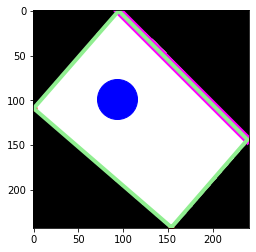

<Figure size 432x288 with 0 Axes>

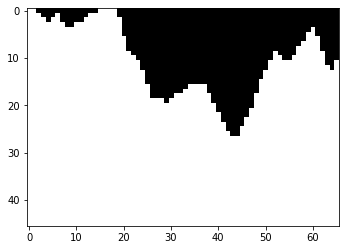

<Figure size 432x288 with 0 Axes>

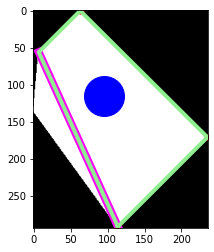

<Figure size 432x288 with 0 Axes>

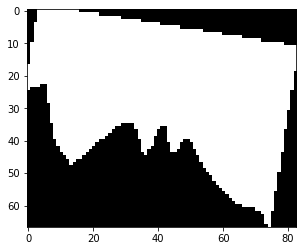

<Figure size 432x288 with 0 Axes>

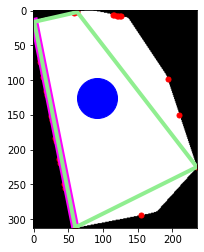

<Figure size 432x288 with 0 Axes>

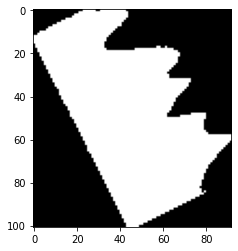

<Figure size 432x288 with 0 Axes>

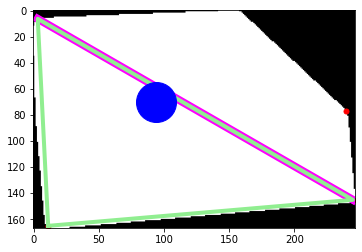

<Figure size 432x288 with 0 Axes>

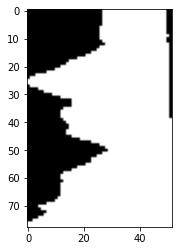

<Figure size 432x288 with 0 Axes>

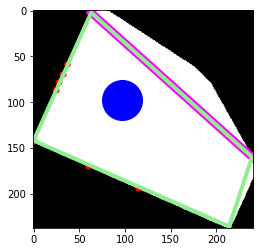

<Figure size 432x288 with 0 Axes>

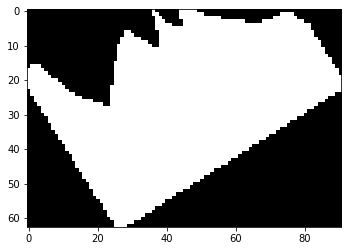

<Figure size 432x288 with 0 Axes>

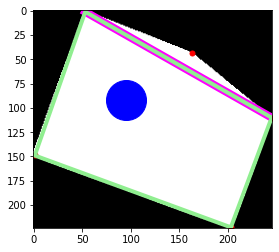

<Figure size 432x288 with 0 Axes>

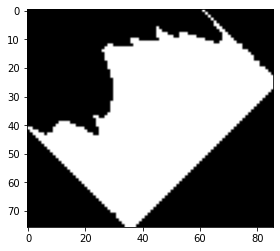

<Figure size 432x288 with 0 Axes>

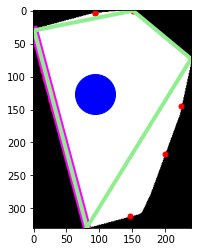

<Figure size 432x288 with 0 Axes>

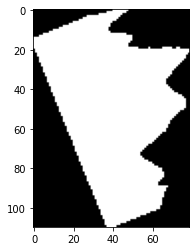

<Figure size 432x288 with 0 Axes>

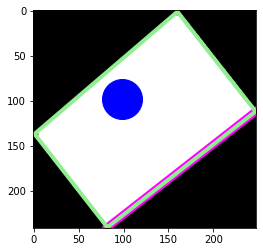

<Figure size 432x288 with 0 Axes>

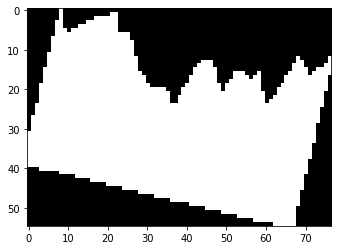

<Figure size 432x288 with 0 Axes>

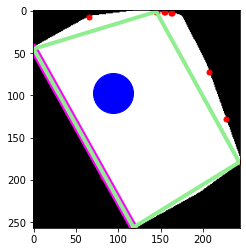

<Figure size 432x288 with 0 Axes>

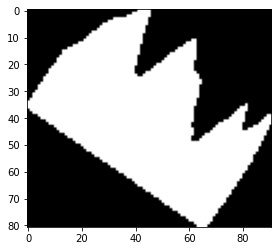

<Figure size 432x288 with 0 Axes>

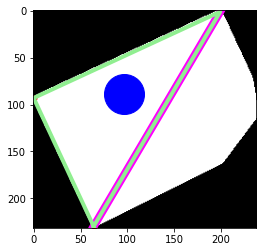

<Figure size 432x288 with 0 Axes>

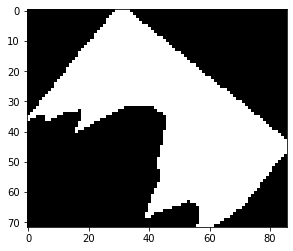

<Figure size 432x288 with 0 Axes>

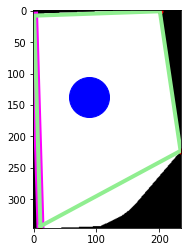

<Figure size 432x288 with 0 Axes>

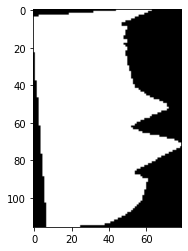

<Figure size 432x288 with 0 Axes>

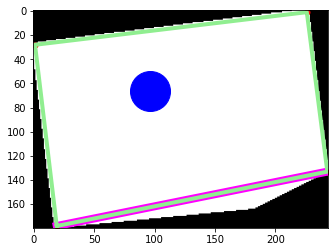

<Figure size 432x288 with 0 Axes>

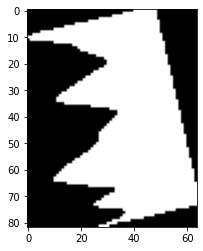

<Figure size 432x288 with 0 Axes>

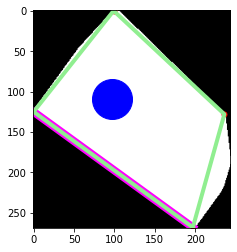

<Figure size 432x288 with 0 Axes>

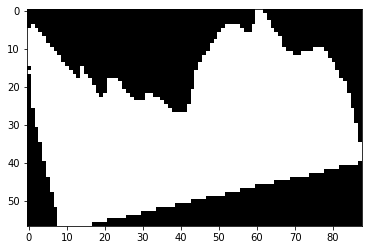

<Figure size 432x288 with 0 Axes>

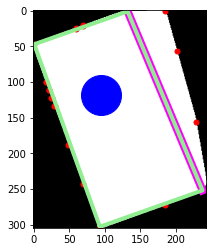

<Figure size 432x288 with 0 Axes>

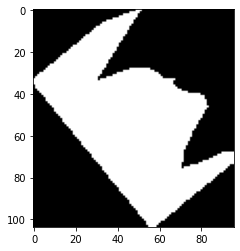

<Figure size 432x288 with 0 Axes>

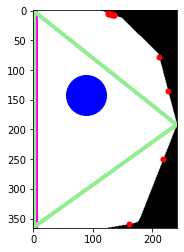

<Figure size 432x288 with 0 Axes>

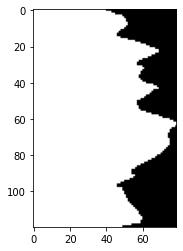

<Figure size 432x288 with 0 Axes>

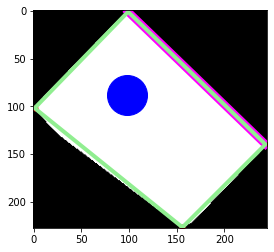

<Figure size 432x288 with 0 Axes>

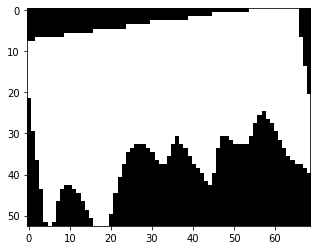

<Figure size 432x288 with 0 Axes>

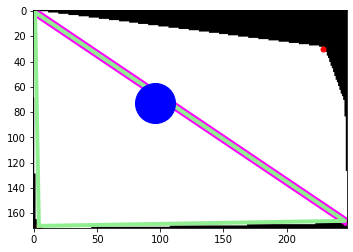

<Figure size 432x288 with 0 Axes>

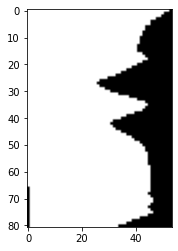

<Figure size 432x288 with 0 Axes>

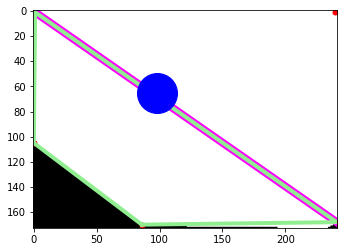

<Figure size 432x288 with 0 Axes>

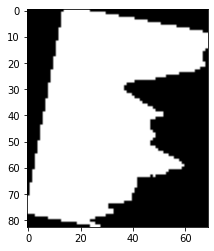

<Figure size 432x288 with 0 Axes>

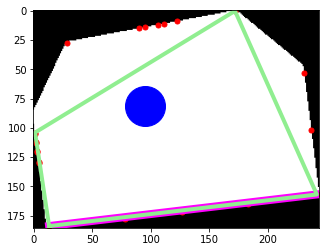

<Figure size 432x288 with 0 Axes>

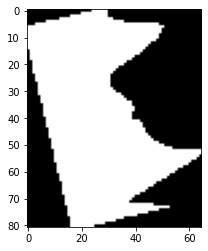

<Figure size 432x288 with 0 Axes>

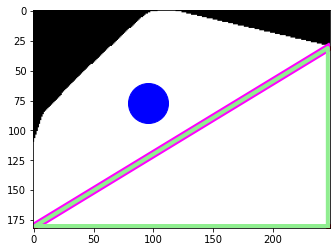

<Figure size 432x288 with 0 Axes>

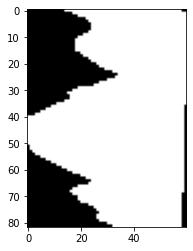

<Figure size 432x288 with 0 Axes>

In [115]:
for image in img:
    
    # ustawia obraz na środku
    image = dropEmptyBorders(image, 4)
    image = normalise_img_size(image, 256)
    image = placeImageInNewAreaCenter(image)

    image_traits = regionprops(img_as_int(image), img_as_int(image))[0]
    
    image_org = image
    image = image_traits.convex_image

    # wyznacza te punkty charakterystyczne; tutaj się okazuje że 32 i .2 dają póki co najlepszy wynik
    coords = corner_peaks(corner_shi_tomasi(image), min_distance=48, threshold_rel=.2, exclude_border=False)
   
    # punkty jako krotki (x,y)
    points = list(zip(coords[:, 0], coords[:, 1]))
    
    # left to skrajnie lewy; top skrajnie górny punkt itd
    used = set()
    
    left = sorted([(x, (x,y)) for x, y in points if (x,y) not in used])[0][1]
    #used.add(left)
    
    right = sorted([(x, (x,y)) for x, y in points if (x,y) not in used])[-1][1]
    #used.add(right)
    
    top = sorted([(y, (x,y)) for x, y in points if (x,y) not in used])[0][1]
    #used.add(top)
    
    bottom = sorted([(y, (x,y)) for x, y in points if (x,y) not in used])[-1][1]
    #new_points = [right, top , left, bottom]
    
    # to tylko do wyświetlania obwodu figury
    pp = np.array([list(x) for x in [right, top , left, bottom, right]])
    
    # a to są te punkty, którze rzekomo tworzą podstawę xd
    # oczywiście to nie działa. nie zawsze
    p = [p1, p2] = np.array(list(findBase(top, bottom, left, right)))
    
    # TODO TODO TODO
    # ogólnie patent jest taki, żeby sprawdzić która prosta z dwoma innymi tworzy kąty proste
    # oczywiście w 90 st się nie wstrzelimy xd
    # więc te najlepsze trzeba będzie wziąć
    # no i rozwiązać problem taki, że np. left i top to te same punkty; gdzieś to widać niżej, 
    # że jest trójkąt zamiast prostokąta

    # kąt do obrotu, też nie zawsze działa, bo trzeba dodać ten przypadek obrotu o 180 jeszcze
    theta = degreesFromLineToXAxis(p1, p2)

    fig, ax = plt.subplots()
    # rysuje obrazek i punkty itd
    # magenta -> podstawa
    # zielony -> obwód
    plt.imshow(image, cmap=plt.cm.gray)
    plt.plot(coords[:, 1], coords[:, 0], color='red', marker='o', linestyle='None', markersize=5)
    plt.plot(p[:, 1], p[:, 0], color='magenta', linewidth=8, markersize=40)
    plt.plot(pp[:, 1], pp[:, 0], color='lightgreen', linewidth=4, markersize=20)
    
    plt.plot(image_traits.weighted_centroid[1]/4, image_traits.weighted_centroid[0]/4, marker='o', color='blue', \
             linewidth=40, markersize=40)
    
    plt.figure()
    plt.show()
    
    
    
    # a tu rysuje po obrocie
    # oczywiście będzie trzeba jeszcze przeskalować obraz, bo ucina trochę obracając
    x = rotate(image_org, math.degrees(image_traits.orientation))
    x = normalise_img_size(x, 256)
    x = dropEmptyBorders(x,1) 
    x = x[2:-2, 2:-2]
    plt.imshow(x, cmap=plt.cm.gray)
    plt.figure()
    plt.show()